In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import sys

import pandas as pd
import embcomp as ec

### Ozette vs Regular

In [16]:
import embcomp as ec

data_dir = pathlib.Path.cwd() / ".." / "data" / "mair-2022-ismb"
name = "TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595"

raw = pd.read_parquet(data_dir / f"{name}_umap.parquet")
annotated = pd.read_parquet(data_dir / f"{name}_umap_annotated.parquet")
raw_knn_indices = ec.metrics.kneighbors(raw[["x", "y"]], k=100)
ann_knn_indices = ec.metrics.kneighbors(annotated[["x", "y"]], k=100)

w = ec.widgets.compare(
    a=ec.widgets.Embedding(
        coords=raw[["x", "y"]],
        knn_indices=raw_knn_indices,
        labels=raw.complete_faust_label,
        robust=raw.cellType != "0_0_0_0_0",
    ),
    b=ec.widgets.Embedding(
        coords=annotated[["x", "y"]],
        knn_indices=ann_knn_indices,
        labels=annotated.complete_faust_label,
        robust=annotated.cellType != "0_0_0_0_0",
    ),
)

w

## Mair 2022

In [21]:
from embcomp.logo import parse_label

def load_embedding(path: str, k = 50, robust_only = False) -> ec.widgets.Embedding:
    df = path if isinstance(path, pd.DataFrame) else pd.read_parquet(path)
    
    if robust_only:
        df = df[df["faustLabels"] != "0_0_0_0_0"].reset_index(drop=True)

    coords = df[["umapX", "umapY"]]
    knn_indices = ec.metrics.kneighbors(coords, k=k)
    labels = df["faustLabels"]
    robust = labels != "0_0_0_0_0"

    robust[0] = False

    # find the first non-robust label
    representative_label = labels[robust].iloc[0]
    df["labels"] = ""
    for marker in parse_label(representative_label):
        marker_annoation = marker.name + df[f"{marker.name}_faust_annotation"]
        df["labels"] += marker_annoation

    labels = df["labels"]

    return ec.widgets.Embedding(
        coords=coords, knn_indices=knn_indices, labels=labels, robust=robust
    )


w = ec.widgets.compare(
    a=load_embedding("../data/mair-2022/OZEXPSMPL_26134_embedding_output.parquet", k=50, robust_only=True),
    b=load_embedding("../data/mair-2022/OZEXPSMPL_26136_embedding_output.parquet", k=50, robust_only=True),
)

w

<AxesSubplot: >

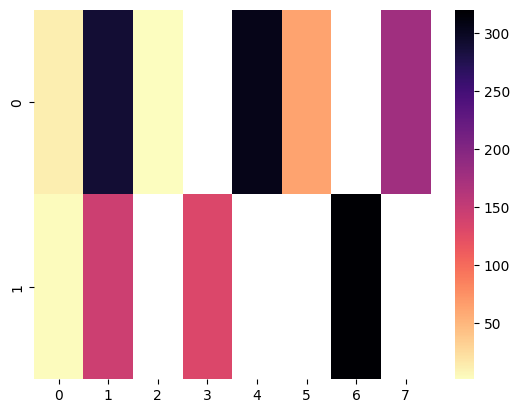

In [25]:
import seaborn as sns
import numpy as np

def view_counts(label: str):
    (acounts, _a), (bcounts, _b) = w.label_counts()
    a, b = (
        counts[np.nonzero(counts.values)[0]]
        for counts in (acounts.loc[label], bcounts.loc[label])
    )
    union = a.index.union(b.index)
    return np.stack([
        union.map(a).values,
        union.map(b).values,
    ])

sns.heatmap(
    view_counts("CD4+CD8-CD3+CD45RA+CD27+CD19-CD103-CD28+CD69-PD1-HLADR-GranzymeB-CD25-ICOS-TCRgd-CD38-CD127+Tim3-"),
    cmap="magma_r",
)

## IFN-γ-independent immune markers of Mycobacterium tuberculosis exposure


In [31]:
import pandas as pd
import pathlib
from utils import load_embedding

def load_ics_example(subset: pd.DataFrame, data_dir = "~/data/ICS_external_analysis"):
    data_dir = pathlib.Path(data_dir)
    for index, row in subset.iterrows():
        df = pd.read_parquet(data_dir / f"{row['oz_id']}_embedding_output.parquet")
        yield load_embedding(df)

def select_subset(
    metadata_file= "../data/ics/ics_experiment_metadata_table.parquet",
):
    df = pd.read_parquet(metadata_file)
    # df = df[df.arm_or_cohort_name == "LTBI"]
    options = [
        # 'TB Lysate',
        'Peptide Pool 1',
        # 'DMSO',
        # 'SEB',
        # 'Peptide Pool 2'
    ]
    df = df[df.Treatment.isin(options)]
    n = 1
    return df.groupby(["Treatment", "arm_or_cohort_name"]).sample(n=n, random_state=123).reset_index(drop=True)

subset = select_subset()
subset

,name,visit_name,biosample_id,visit_id,expsample_id,arm_or_cohort_id,Treatment,arm_or_cohort_name,subject_id,oz_id
0,68bd69b2-4ef6-4628-b87b-06e243a01f94,V0,1375,329,1483,323,Peptide Pool 1,LTBI,812,OZEXPSMPL_2022
1,d5c7e837-8014-429c-827e-ef05a19c6efb,V0,1284,329,1381,321,Peptide Pool 1,RSTR,721,OZEXPSMPL_2054


In [32]:
print(f"left: {subset.arm_or_cohort_name.loc[0]}, right: {subset.arm_or_cohort_name.loc[1]}")
w = ec.widgets.compare(*load_ics_example(subset))
w

left: LTBI, right: RSTR


In [30]:
import numpy as np

phenoa = "CD4+CD3+CD8-TNF+CD107a-IL4-IFNg+IL2+CD154+IL17a-"
phenob = "CD4+CD3+CD8-TNF-CD107a-IL4-IFNg-IL2+CD154+IL17a-"

# highlight a specific label
w.left.scatter.widget.selection = np.where(w.left.labels == phenoa)[0]